In [51]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # Uncomment to disable GPU
import glob
import random
import Levenshtein as lv

from model import Model, DatasetName, load_model, remove_model

__ORIG_WD__ = os.getcwd()

os.chdir(f"{__ORIG_WD__}/../data_collectors/")
from covid19_genome import Covid19Genome

os.chdir(__ORIG_WD__)


In [52]:
model_name = "covid19-1024examples"
model = load_model(model_name)

#### Extract examples from lineages you did not train on.

In [53]:
dc = Covid19Genome()

Building Data frame
Done building Data frame
Building remote dicts
Done building remote dicts
Building local dicts
Done building local dicts


In [54]:
accessions_threshold = 1024

In [55]:
lineage_to_accessions_map = {}
accession_to_lineage_map ={}
lineages = dc.getLocalLineages(0)
for lineage in lineages:
    lineage_to_accessions_map[lineage] = []
    accessions = dc.getLocalAccessionsPath(lineage)
    for accession in accessions:
        lineage_to_accessions_map[lineage].append(accession)
        accession_to_lineage_map[accession] = lineage

accessions_of_unknown_lineages = []
for accession, lineage in accession_to_lineage_map.items():
    if len(lineage_to_accessions_map[lineage]) < accessions_threshold:
        accessions_of_unknown_lineages.append(accession)

random.shuffle(accessions_of_unknown_lineages)


In [56]:
sequencer_instrument_to_error_profile_map = {
    "illumina": {
        "substitution_rate": 0.005,
        "insertion_rate": 0.001,
        "deletion_rate": 0.001
    },
    "ont": {
        "substitution_rate": 0.01,
        "insertion_rate": 0.04,
        "deletion_rate": 0.04
    },
    "pacbio": {
        "substitution_rate": 0.005,
        "insertion_rate": 0.025,
        "deletion_rate": 0.025
    },
    "roche": {
        "substitution_rate": 0.002,
        "insertion_rate": 0.01,
        "deletion_rate": 0.01
    }
}

In [8]:
coverage = 4
ml_model_depth = 2
sequencer_instrument = "roche"

def get_model_name(ml_model_depth, coverage, sequencer_instrument):
    if not sequencer_instrument in sequencer_instrument_to_error_profile_map:
        raise Exception(f"Invalid sequencer instrument: {sequencer_instrument}")
    return f"vit.{ml_model_depth}.{coverage}x.{sequencer_instrument}"

ml_model_name = get_model_name(ml_model_depth, coverage, sequencer_instrument)

In [85]:
meow = model.predict(
    ml_model_name,
    model.get_ds_types()[0],
    dataset_props= {
        "coverage": 4,
    } | sequencer_instrument_to_error_profile_map[sequencer_instrument],
    examples=accessions_of_unknown_lineages[:128]

)

In [ ]:
import tensorflow as tf

labels = model.get_labels()

example_number = 1

example_id = meow[example_number][0]

top_5_label_values, top_5_label_indices = tf.math.top_k(meow[example_number][1], k=5)
down_5_label_values, down_5_label_indices = tf.math.top_k(-1*meow[example_number][1], k=5)

top_5_labels = [labels[i] for i in top_5_label_indices]
down_5_labels = [labels[i] for i in down_5_label_indices]


print("Tested accession: "accession_to_lineage_map[example_id])
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Top 5 labels:")
for i in range(5):
    print(f"{top_5_labels[i]}: {top_5_label_values[i]}")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Down 5 labels:")
for i in range(5):
    print(f"{down_5_labels[i]}: {-1*down_5_label_values[i]}")

<BarContainer object of 5 artists>

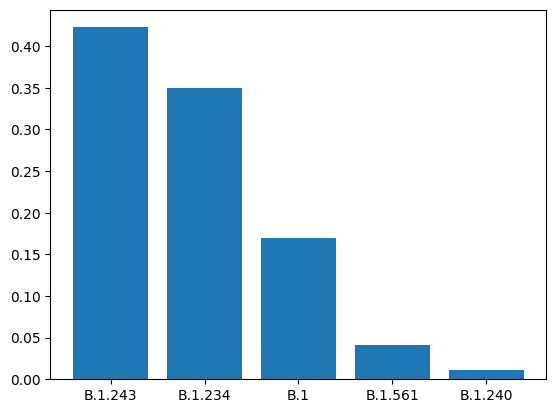

In [104]:
# plot the labels and their values
import matplotlib.pyplot as plt

plt.bar(top_5_labels, top_5_label_values)

<BarContainer object of 5 artists>

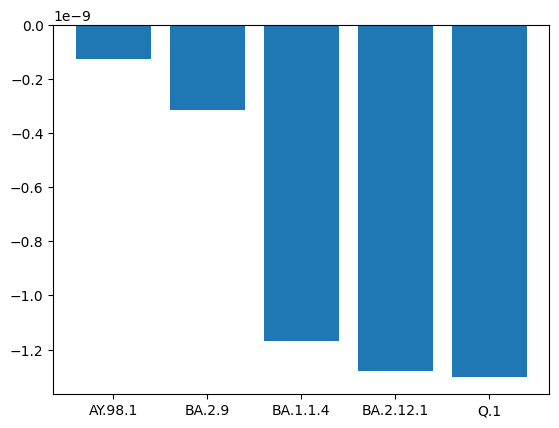

In [105]:
plt.bar(down_5_labels, down_5_label_values)

In [96]:
def get_genome(input_filepath):
    genome = ""
    with open(input_filepath, "r") as f:
        for line in f:
            if line.startswith(">"):
                continue
            genome += line.strip()
    return genome

In [97]:
example_genome = get_genome(example_id)

In [98]:
for lineage in top_5_labels:
    accession = lineage_to_accessions_map[lineage][0]
    lineage_genome = get_genome(accession)
    print(lv.ratio(example_genome, lineage_genome))
print("~~~~~~~~~~~~~~~~")
for lineage in down_5_labels:
    accession = lineage_to_accessions_map[lineage][0]
    lineage_genome = get_genome(accession)
    print(lv.ratio(example_genome, lineage_genome))

0.9860341759828113
0.9804821658932131
0.9861679983885047
0.939733479309578
0.9861777434830744
~~~~~~~~~~~~~~~~
0.9064198027772188
0.9827828766664434
0.9827493803175454
0.9835164835164835
0.9842860014742344


In [99]:
# print the avarage of the top 5 against the bottom 5
top_5_avg = 0
for lineage in top_5_labels:
    accession = lineage_to_accessions_map[lineage][0]
    lineage_genome = get_genome(accession)
    top_5_avg += lv.ratio(example_genome, lineage_genome)
top_5_avg /= 5

down_5_avg = 0
for lineage in down_5_labels:
    accession = lineage_to_accessions_map[lineage][0]
    lineage_genome = get_genome(accession)
    down_5_avg += lv.ratio(example_genome, lineage_genome)
down_5_avg /= 5

print(top_5_avg)
print(down_5_avg)

0.9757191126114364
0.967950908950385


In [111]:
lineages = dc.getLocalLineages(1024)
# sort(lineages)

In [112]:
# write list of lineages to file
with open("lineages.txt", "w") as f:
    for lineage in lineages:
        f.write(f"{lineage}\n")